In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('Agg')
import os
import h5py
import json
import re
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import pickle
import glob
from scipy.optimize import curve_fit

from pipeline.python.utils import natural_keys, label_figure, replace_root

pp = pprint.PrettyPrinter(indent=4)

#%%

In [2]:

#-----------------------------------------------------
#           FUNCTIONS FOR DATA PROCESSING
#-----------------------------------------------------

def block_mean(ar, fact):
	assert isinstance(fact, int), type(fact)
	sx, sy = ar.shape
	X, Y = np.ogrid[0:sx, 0:sy]
	regions = sy/fact * (X/fact) + Y/fact
	res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
	res.shape = (sx/fact, sy/fact)
	return res

def block_mean_stack(stack0, ds_factor, along_axis=2):
    if along_axis==2:
	im0 = block_mean(stack0[:,:,0],ds_factor) 
        print im0.shape
	stack1 = np.zeros((im0.shape[0],im0.shape[1],stack0.shape[2]))
	for i in range(0,stack0.shape[2]):
            stack1[:,:,i] = block_mean(stack0[:,:,i],ds_factor) 
    else:
 	im0 = block_mean(stack0[0,:,:],ds_factor) 
	stack1 = np.zeros((stack0.shape[0], im0.shape[0], im0.shape[1]))
	for i in range(stack0.shape[0]):
            stack1[i,:,:] = block_mean(stack0[i,:,:],ds_factor) 

    return stack1

def smooth_array(inputArray,fwhm):
	szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
	sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
	sigma=sigmaList[fwhm]
	sz=szList[fwhm]

	outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
	return outputArray

def smooth_stack(stack0, fwhm):
	stack1 = np.zeros(stack0.shape)
	for i in range(0,stack0.shape[2]):
		stack1[:,:,i] = smooth_array(stack0[:,:,i], fwhm) 
	return stack1

def get_processed_stack(tiff_path_full,RETINOID):
	# Read in RAW tiff: 
	print('Loading file : %s'%(tiff_path_full))
	stack0 = tf.imread(tiff_path_full)
        print stack0.shape
	#swap axes for familiarity
	stack1 = np.swapaxes(stack0,0,2)
	stack1 = np.swapaxes(stack1,1,0)
	del stack0 # to save space

	#block-reduce, if indicated
	if RETINOID['PARAMS']['downsample_factor'] is not None:
		print('Performing block-reduction on stack....')
		stack1 = block_mean_stack(stack1, int(RETINOID['PARAMS']['downsample_factor']))

	#spatial smoothing, if indicated
	if RETINOID['PARAMS']['smooth_fwhm'] is not None:
		print('Performing spatial smoothing on stack....')
		stack1 = smooth_stack(stack1, int(RETINOID['PARAMS']['smooth_fwhm']))
	return stack1
		
def process_array(roi_trace, RETINOID, stack_info):
	
	frame_rate = stack_info['frame_rate']
	stimfreq = stack_info['stimfreq']
	#hard-code for now, in the future, get from mworks file
	if RETINOID['PARAMS']['minus_rolling_mean']:
		print('Removing rolling mean from traces...')
		detrend_roi_trace = np.zeros(roi_trace.shape)

		windowsz = int(np.ceil((np.true_divide(1,stimfreq)*3)*frame_rate))

		for roi in range(roi_trace.shape[0]):
			tmp0=roi_trace[roi,:];
			tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

			rolling_mean=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
			rolling_mean=rolling_mean[windowsz:-windowsz]

			detrend_roi_trace[roi,:]=np.subtract(tmp0,rolling_mean)
		roi_trace = detrend_roi_trace
		del detrend_roi_trace
	if RETINOID['PARAMS']['average_frames'] is not None:
		print('Performing temporal smoothing on traces...')
		smooth_roi_trace = np.zeros(roi_trace.shape)

		windowsz = int(RETINOID['PARAMS']['average_frames'])

		for roi in range(roi_trace.shape[0]):
			tmp0=roi_trace[roi,:];
			tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

			tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
			tmp2=tmp2[windowsz:-windowsz]

			smooth_roi_trace[roi,:]=tmp2
		roi_trace = smooth_roi_trace
		del smooth_roi_trace
	return roi_trace

def do_regression(t,phi,roi_trace,npixels,tpoints,roi_type,signal_fit_idx):
	print('Doing regression')
	#doing regression to get amplitude and variance expained
	t=np.transpose(np.expand_dims(t,1))
	tmatrix=np.tile(t,(npixels,1))

	phimatrix=np.tile(phi,(1,tpoints))
	Xmatrix=np.cos(tmatrix+phimatrix)

	beta_array=np.zeros((npixels))
	varexp_array=np.zeros((npixels))
	if roi_type != 'pixels':
		signal_fit = np.zeros((npixels,tpoints))

	for midx in range(npixels):
		x=np.expand_dims(Xmatrix[midx,:],1)
		y=roi_trace[midx,:]
		beta=np.matmul(np.linalg.pinv(x),y)
		beta_array[midx]=beta
		yHat=x*beta
		if roi_type == 'pixels':
			if midx == signal_fit_idx:
				signal_fit=np.squeeze(yHat)
		else:
			signal_fit[midx,:]=np.squeeze(yHat)
		SSreg=np.sum((yHat-np.mean(y,0))**2)
		SStotal=np.sum((y-np.mean(y,0))**2)
		varexp_array[midx]=SSreg/SStotal

	return varexp_array, beta_array, signal_fit


## Load retinotopy run source

In [5]:
#rootdir = '/n/coxfs01/2p-data' #
rootdir = '/mnt/odyssey'
animalid = 'CE077'
session = '20180523'
acquisition = 'FOV1_zoom1x'
run = 'retino'
analysis_id = 'analysis004'
default = False
slurm = False


In [6]:
acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)
run_dir = glob.glob(os.path.join(acquisition_dir, 'retino*'))[0]
run = os.path.split(run_dir)[1]

retino_roi_analysis = glob.glob(os.path.join(rootdir, animalid, session, acquisition, 'retino*', 'retino_analysis', 'analysis*', 'visualization'))[0]
print retino_roi_analysis

retinoids_fpath = glob.glob(os.path.join(acquisition_dir, 'retino*', 'retino_analysis', 'analysisids_*.json'))[0]
retinoid_dir = os.path.split(retino_roi_analysis)[0]
retinoid = os.path.split(retinoid_dir)[1]

with open(retinoids_fpath, 'r') as f: rids = json.load(f)
RID = rids[retinoid.split('_')[0]]
pp.pprint(RID)


/mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393/visualization
{   u'DST': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393',
    u'PARAMS': {   u'average_frames': u'5',
                   u'downsample_factor': u'2',
                   u'excluded_tiffs': [],
                   u'hashid': u'0f3eac',
                   u'minus_rolling_mean': True,
                   u'rid_hash': u'2e3286',
                   u'roi_id': u'rois002',
                   u'roi_type': u'manual2D_warp',
                   u'signal_channel': 1,
                   u'smooth_fwhm': None,
                   u'tiff_source': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896'},
    u'SRC': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896',
    u'analysis_hash': u'4a6393',
    u'analysis_id': u'analysis001'}


## Get meta info for current run and source tiffs using analysis-ID params:

In [7]:

# =============================================================================
# Get meta info for current run and source tiffs using analysis-ID params:
# =============================================================================
analysis_hash = RID['analysis_hash']

tiff_dir = RID['SRC']
if rootdir not in tiff_dir:
    tiff_dir = replace_root(tiff_dir, rootdir, animalid, session)
    
tiff_fpaths = sorted([os.path.join(tiff_dir, t) for t in os.listdir(tiff_dir) if t.endswith('tif')], key=natural_keys)
#print "Found %i tiffs in dir %s.\nExtracting analysis with ROI set %s." % (len(tiff_files), tiff_dir, roi_name)

# Get associated RUN info:
runmeta_path = os.path.join(run_dir, '%s.json' % run)
with open(runmeta_path, 'r') as r:
    runinfo = json.load(r)

nslices = len(runinfo['slices'])
nchannels = runinfo['nchannels']
nvolumes = runinfo['nvolumes']
ntiffs = runinfo['ntiffs']

ORIG ROOT: /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896
NEW ROOT: /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896


## Load paradigm info

In [8]:
print 'Getting paradigm file info'
paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(paradigm_fpath, 'r') as r: mwinfo = json.load(r)
# pp.pprint(mwinfo)

Getting paradigm file info


# Load ROI traces for averaged retino conditions

In [25]:
def get_retino_traces(RID, retinoid_dir, mwinfo, tiff_fpaths, create_new=False):

    # Set output dir:
    output_dir = os.path.join(retinoid_dir,'traces')
    if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    print output_dir

    avg_trace_fpath = os.path.join(output_dir, 'averaged_roi_traces.pkl')
    if os.path.exists(avg_trace_fpath) and create_new is False:
        with open(avg_trace_fpath, 'rb') as f:
            traces = pkl.load(f)
    else:
        acquisition_dir = os.path.split(retinoid_dir.split('/retino_analysis')[0])[0]
        session_dir = os.path.split(acquisition_dir)[0]
        masks = load_roi_masks(session_dir, RID)

        # Block reduce masks to match downsampled tiffs:
        masks = block_mean_stack(masks, int(RID['PARAMS']['downsample_factor']), along_axis=0)
        print masks.shape

        # Combine reps of the same condition.
        # Reshape masks and averaged tiff stack, extract ROI traces
        traces = average_retino_traces(RID, mwinfo, tiff_fpaths, masks)
        
    return traces

In [26]:

def average_retino_traces(RID, mwinfo, tiff_fpaths, masks):
    
    rep_list = [(k, v['stimuli']['stimulus']) for k,v in mwinfo.items()]
    unique_conditions = np.unique([rep[1] for rep in rep_list])
    conditions = dict((cond, [int(run) for run,config in rep_list if config==cond]) for cond in unique_conditions)
    print conditions
    cstack = get_averaged_condition_stack(conditions, tiff_fpaths, RID)

    rtraces = {}
    for curr_cond in cstack.keys():
        roi_traces = apply_masks_to_tifs(masks, cstack[curr_cond])
        print roi_traces.shape
        rtraces[curr_cond] = roi_traces

    # Smooth roi traces:
    traceinfo = dict((cond, dict()) for cond in rtraces.keys())
    for curr_cond in rtraces.keys():
        # get some info from paradigm and run file
        stack_info = dict()
        stack_info['stimulus'] = curr_cond
        stack_info['stimfreq'] = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stack_info['frame_rate'] = runinfo['frame_rate']
        stack_info['n_reps'] = len(conditions[curr_cond])
        pp.pprint(stack_info)

        traces = process_array(rtraces[curr_cond], RID, stack_info)

        traceinfo[curr_cond]['traces'] = traces
        traceinfo[curr_cond]['info'] = stack_info

    traces = {'mwinfo': mwinfo,
             'conditions': conditions,
             'source_tifs': tiff_fpaths,
             'RETINOID': RID,
              'masks': masks,
              'traces': traceinfo
             }
    avg_trace_fpath = os.path.join(output_dir, 'averaged_roi_traces.pkl')
    with open(avg_trace_fpath, 'wb') as f: pkl.dump(traces, f, protocol=pkl.HIGHEST_PROTOCOL)
    print "Saved processed ROI traces to:\n%s\n" % avg_trace_fpath
    return traces

In [27]:
def load_roi_masks(session_dir, RID):
    assert RID['PARAMS']['roi_type'] != 'pixels', "ROI type for analysis should not be pixels. This is: %s" % RID['PARAMS']['roi_type']
    print 'Getting masks'
    # Load ROI set specified in analysis param set:
    roidict_fpath = glob.glob(os.path.join(session_dir, 'ROIs', 'rids_*.json'))[0]
    with open(roidict_fpath, 'r') as f: roidict = json.load(f)

    roi_dir = roidict[RID['PARAMS']['roi_id']]['DST']
    if rootdir not in roi_dir:
        roi_dir = replace_root(roi_dir, rootdir, animalid, session)
    mask_fpath = os.path.join(roi_dir, 'masks.hdf5')
    maskfile = h5py.File(mask_fpath,  'r')#read
    masks = maskfile[maskfile.keys()[0]]['masks']['Slice01']
    print masks.shape
    
    return masks

In [28]:
def get_averaged_condition_stack(conditions, tiff_fpaths, RID):
    cstack = {}
    condition_list = conditions.keys()
    curr_cond = 'right'
    for curr_cond in condition_list:
        curr_tiff_fpaths = [tiff_fpaths[int(i)-1] for i in conditions[curr_cond]]
        for tidx, tiff_fpath in enumerate(curr_tiff_fpaths):    
            print "Loading: ", tiff_fpath
            tiff_stack = get_processed_stack(tiff_fpath, RID)
            szx, szy, nframes = tiff_stack.shape
            print szx, szy, nframes
            if tidx == 0:
                # initiate stack
                stack = np.empty(tiff_stack.shape, dtype=tiff_stack.dtype)
            stack =  stack + tiff_stack

        # Get stack average:
        cstack[curr_cond] = stack / len(curr_tiff_fpaths)

    return cstack

In [29]:
def apply_masks_to_tifs(masks, stack):
    szx, szy, nframes = stack.shape
    nrois = masks.shape[0]
    maskr = np.reshape(masks, (nrois, szx*szy))
    stackr = np.reshape(stack, (szx*szy, nframes))
    print "masks:", maskr.shape
    print "stack:", stackr.shape
    roi_traces = np.dot(maskr, stackr)
    return roi_traces

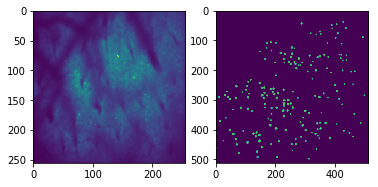

In [28]:
#pl.figure(); pl.subplot(1,2,1); pl.imshow(np.mean(cstack['right'], axis=-1));
#pl.subplot(1,2,2); pl.imshow(np.sum(masks, axis=0))

### Process raw tiff arrays or Load if exists:

#### Check if file exists:

In [30]:
create_new = False

traces = get_retino_traces(RID, retinoid_dir, mwinfo, tiff_fpaths, create_new=create_new)


/mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393/traces


In [32]:
print "Conditions:",  traces['traces'].keys()

traceinfo =  traces['traces']

Conditions: [u'top', u'right']


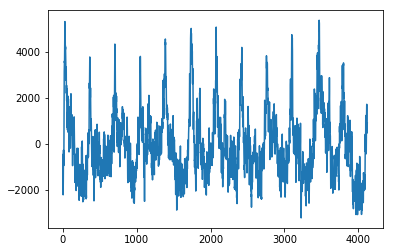

In [24]:
pl.figure(); pl.plot(roi_traces['right']['traces'][2,:])

##### Load screen info

In [150]:
try:
    assert len(glob.glob(os.path.join(rootdir, animalid, 'epi*', '*.json'))) > 0, "No .json file found in epi_maps"
    screen_info_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi*', '*.json'))[0]
except Exception as e:
    assert len(glob.glob(os.path.join(rootdir, animalid, 'epi*', '20*', '*.json'))) > 0, "No .json file found in epi_maps"
    screen_info_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi*', '20*', '*.json'))[0]
print "Loading screen info from: %s" % screen_info_fpath
with open(screen_info_fpath, 'r') as f:
    screen_info = json.load(f)


if 'screen_size_t_degrees' in screen_info['screen_params'].keys():
    el_degrees_per_cycle = screen_info['screen_params']['screen_size_t_degrees']
else:
    el_degrees_per_cycle = screen_info['screen_params']['screen_size_y_degrees']
az_degrees_per_cycle = screen_info['screen_params']['screen_size_x_degrees']


Loading screen info from: /mnt/odyssey/CE077/epi_maps/20180525/screen_boundaries_CE077epi_5_23_2018_run9_fwhm_5_thresh_0.02.json


In [151]:
frate = runinfo['frame_rate']
nframes = runinfo['nvolumes']

#### Average all cycles to fit curve

In [68]:
from scipy.optimize import curve_fit

def func(x, sigmag, mu, alpha, c,a):
    #normal distribution
    normpdf = (1/(sigmag*np.sqrt(2*math.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    normcdf = (0.5*(1+sp.erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [200]:
class ActivityInfo:
    def __init__(self, condition, roi_trace):
        self.name = condition
        self.activity_trace = roi_trace
        
    def parse_cycles(self, framestart, stimframes_incl):
        ncyles = len(framestart)
        parsed_traces = np.zeros((ncycles,stimframes_incl))
        for cycle in range(0,ncycles):
            parsed_traces[cycle,:]=self.activity_trace[framestart[cycle]:framestart[cycle]+stimframes_incl]
        self.parsed_traces = parsed_traces
        

    def fit_gaussian_to_trace(self):
        x0 = np.arange(0,self.parsed_traces.shape[-1])
        y = np.mean(self.parsed_traces, axis=0) #-y0.min()
        try:
            center_start = np.argmax(y)-(np.argmax(y)/1)
            center_end = np.argmax(y)+(np.argmax(y)/1)*2
            if center_start < 0:
                center_start = 0
            if center_end > len(y):
                center_end = len(y)
            centered = y[np.arange(center_start, center_end)]
            popt, pcov = curve_fit(gaus, x0, y, p0=(y[np.argmax(y)], np.argmax(y), 1))

            y_fit = gaus(x0,*popt)
            print(popt)

            ss_res = np.sum((y - y_fit)**2)
            ss_tot = np.sum((y-np.mean(y))**2)
            r_squared = 1 - (ss_res / ss_tot)
            print("R2:", r_squared)

        except RuntimeError:
            print("Error - curve_fit failed")
        
        self.average_y = y
        self.fit_results = {'r2': r_squared,
                           'A': A,
                           'x0': x0,
                           'sigma': sigma,
                           'y_fit': y_fit}
        
    def estimate_RF_size(self, frames_per_degree, fitness_threshold=0.5, size_threshold=0.1):

        if self.fit_results['r2'] > fitness_threshold:
            
            y = self.average_y
            y_fit = self.fit_results['y_fit']
            
            fit_norm = y_fit/np.max(y_fit)

            border_start = np.where(fit_norm>=size_threshold)[0]
            if len(border_start)==0:
                border_start = 0
            else:
                border_start = border_start[0]
            border_end = np.where(fit_norm[border_start:]<=size_threshold)[0]
            if len(border_end) == 0:
                border_end = len(fit_norm)-1
            else:
                border_end = border_end[0]
            #print(border_start, border_end) #rf_size_frames)

            # extrapolate around peak, in case edge:
            peak = np.argmax(y)
            tail2 = border_end - peak
            tail1 = peak - border_start
            if tail1 < tail2:
                border_edge1 = peak - tail2
                border_edge2 = peak + tail2
            elif tail2 < tail1:
                border_edge2 = peak + tail1
                border_edge1 = peak - tail1
            else:
                border_edge1 = peak - tail1
                border_edge2 = peak + tail2

            rf_size_frames = border_edge2 - border_edge1
            print rf_size_frames
        else:
            rf_size_frames = 0
            peak = 0
            border_start = 0; border_end = 0
            
        self.peak_ix = peak
        self.borders = (border_start, border_end)
        self.RF_frames = rf_size_frames
        self.RF_degrees = rf_size_frames / frames_per_degree

        
class RetinoROI:
    def __init__(self, roi_ix):
        self.name = 'roi%06d' % (roi_ix+1)
        self.idx = roi_ix
        self.conditions = []
    
    def parse(self, condition, roi_trace, framestart, stimframes_incl):
        cond_ix = [ci for ci, cond in enumerate(self.conditions) if cond.name==condition]
        if len(cond_ix) == 0:
            self.conditions.append(ActivityInfo(condition, roi_trace))
            cond_ix = -1
        else:
            cond_ix = cond_ix[0]
            
        self.conditions[cond_ix].parse_cycles(framestart, stimframes_incl)
    
    def fit(self, condition, frames_per_degree, fitness_threshold=0.5, size_threshold=0.1):
        cond_ix = [ci for ci, cond in enumerate(self.conditions) if cond.name==condition]
        if len(cond_ix) == 0:
            self.conditions.append(ActivityInfo(condition, roi_trace))
            cond_ix = 0
        else:
            cond_ix = cond_ix[0]
        self.conditions[cond_ix].fit_gaussian_to_trace()
        self.conditions[cond_ix].estimate_RF_size(frames_per_degree, )
    
    def print_info(self):
        for cond in self.conditions:
            print "Name: %s | RF size (deg): %i" % (self.name, cond.RF_degrees)


### Fit gaussian to average response to cycle:

In [300]:
fitness_threshold = 0.4
size_threshold = 0.1


In [301]:
ROIs = []
for curr_roi in range(roi_traces.shape[0]):
    roi = RetinoROI(curr_roi)

    for curr_cond in traceinfo.keys():
        print curr_cond
        stack_info = traceinfo[curr_cond]['info']
        roi_traces = traceinfo[curr_cond]['traces']

        # Get frame info for current cond
        stimfreq = stack_info['stimfreq']
        stimperiod = 1.0/stimfreq

        ncycles = int(round((nframes/frate) / stimperiod))

        stimframes_start_int= stimperiod*frate
        stimframes_incl = int(np.floor(stimperiod*frate))
        framestart = np.round(np.arange(0,stimframes_start_int*ncycles,stimframes_start_int)).astype('int')

        # Get screen info for current cond:
        nframes_per_cycle = stimframes_incl
        cycles_per_sec = stack_info['stimfreq']

        if curr_cond == 'right' or curr_cond == 'left':
            cycles_per_degree = az_degrees_per_cycle
        else:
            cycles_per_degree = el_degrees_per_cycle

        frames_per_degree = nframes_per_cycle / cycles_per_degree
        #print frames_per_degree

        roi.parse(curr_cond, roi_traces[curr_roi, :], framestart, stimframes_incl)
        roi.fit(curr_cond, frames_per_degree, fitness_threshold=fitness_threshold, size_threshold=size_threshold)
        
    ROIs.append(roi)

top
[ 6146.10240648   266.61344085     9.42411236]
('R2:', 0.51884919217717806)
40
right
[ 3613.92514546   322.22235014    22.97331503]
('R2:', 0.65174686787898084)
104
top
[ 2064.75728829   249.00866516    26.45777152]
('R2:', 0.5855651264238817)
150
right
[ 4325.947431      17.98288974    15.31178648]
('R2:', 0.69142321418622021)
72
top
[ 2396.27598912   246.63264008    26.73127693]
('R2:', 0.62519202289836329)
160
right
[ 3022.26699079    19.27888859    15.98485631]
('R2:', 0.56029311335947041)
78
top
[ 787.52599229  102.88898602   14.68721909]
('R2:', 0.3613674396915677)
right
[ 497.91026948   27.99858354   18.63069196]
('R2:', 0.60340458403209318)
84
top
[ 2057.15724423   259.77832882    24.75839114]
('R2:', 0.67429871557973309)
128
right
[ 808.80503735   25.20235747   18.47805541]
('R2:', 0.47139990853112212)
top
[ 2188.32100974   160.13515125    25.21063393]
('R2:', 0.6548328239876392)
114
right
[ 1133.07955902   315.87422516    18.09349535]
('R2:', 0.37067087702833024)
top
[ 22

[ 453.46820955  347.00579793   64.46330599]
('R2:', 0.43499905634978808)
top
[ 722.907187    136.35438686   28.86790574]
('R2:', 0.54141203966175189)
154
right
[ 577.99314908  319.69641739   36.40650246]
('R2:', 0.51729671831004154)
166
top
[ 458.67382709  128.12045067   22.71195237]
('R2:', 0.44904364577222078)
right
[ 343.22613078   29.47536885    6.3911858 ]
('R2:', 0.24538895806999417)
top
[ 874.05506703  123.66585986   24.46345983]
('R2:', 0.67242296572607152)
92
right
[ 448.97948394   26.60426436    6.32615329]
('R2:', 0.39247257041826955)
top
[ 1890.59091004   145.60710082    27.60113569]
('R2:', 0.72266738672440944)
100
right
[ 707.76356017  166.91966295   39.68794971]
('R2:', 0.53756181560470928)
202
top
[ 440.1796637   107.39817126   35.77723028]
('R2:', 0.3446784852965955)
right
[ 325.54002354  183.2598432    28.49028563]
('R2:', 0.47989606976796351)
top
[ 1176.34819788   159.56371356    22.4050864 ]
('R2:', 0.74128763944890586)
104
right
[ 458.75887289  173.66263364   38.80

[ 3992.22910724    98.91034385    10.93306109]
('R2:', 0.31435849625369883)
right
[ 2239.57875292   327.73206601     9.04867989]
('R2:', 0.24963180726262624)
top
[ 2680.66260299   255.49832263    16.74138514]
('R2:', 0.2120684716718928)
right
[ 2890.95546571    23.39417774    13.02655465]
('R2:', 0.37385406846787095)
top
[ 1405.67621766   187.07510352    32.58231555]
('R2:', 0.45753389649220921)
right
[ 1798.728769     305.98185609    21.85873968]
('R2:', 0.79236296814649587)
86
top
[ 1182.71780237   170.51407305    21.17330492]
('R2:', 0.53558785271326048)
68
right
[ 772.43586507  309.07965879   26.14743601]
('R2:', 0.68608845476141911)
128
top
[ 1195.79297987   146.6034158     29.46601728]
('R2:', 0.42453479956727558)
right
[ 1549.83970949   319.57367961    18.23497334]
('R2:', 0.72763677850768105)
96
top
[ 1576.77081107   262.33369055     9.4807993 ]
('R2:', 0.15731273126307088)
right
[ 1953.63913494   316.43587482    18.67431146]
('R2:', 0.74008262293096072)
98
top
[ 1206.75907404 

In [302]:
az_rfs = [roi.conditions[0].RF_degrees for roi in ROIs]

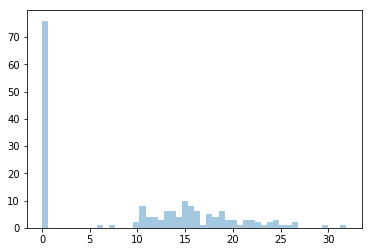

In [303]:
import seaborn as sns
sns.distplot(az_rfs, kde=False, bins=50)

In [207]:
from pipeline.python.retinotopy import visualize_rois as vis

/home/juliana/Repositories/2p-pipeline/pipeline/python/retinotopy/visualize_rois.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

In [304]:
dfpaths = vis.get_retino_datafile_paths(acquisition_dir, run, retinoid.split('_')[0])

dataframes = vis.get_metricdf(dfpaths)
zdf = vis.assign_mag_ratios(dataframes, run, stat_type='mean', metric_type='magratio') #=stat_type, run2_stat_type=stat_type)
print zdf.head()
retino_info = vis.get_retino_info(azimuth='right', elevation='top')
rundf = dataframes[run]['df']


Getting mag-ratios for each ROI in run: retino_run1, trial 1
Getting mag-ratios for each ROI in run: retino_run1, trial 2
Getting mag-ratios for each ROI in run: retino_run1, trial 3
Getting mag-ratios for each ROI in run: retino_run1, trial 4
Getting mag-ratios for each ROI in run: retino_run1, trial 5
Getting mag-ratios for each ROI in run: retino_run1, trial 6
          magratio_mean1
roi                     
roi00001        0.064481
roi00002        0.063102
roi00003        0.018572
roi00004        0.087924
roi00005        0.054349
center 2 Top/Anterior: 22.0 40.0


In [305]:
linX, linY, linC = vis.convert_lincoords_lincolors(rundf, retino_info)

In [306]:
# Get RGBA mapping normalized to mag-ratio values:
import matplotlib as mpl
# curr_metric = 'magratio_mean1'
# norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
# cmap = mpl.cm.get_cmap('hsv')
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# rgbas = np.array([mapper.to_rgba(v) for v in linC])
# alphas = np.array(zdf[curr_metric] / zdf[curr_metric].max())
magratios = zdf[curr_metric]

(-22.0, 22.0)

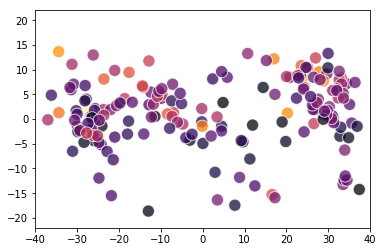

In [307]:
pl.figure()
pl.scatter(linX, linY, s=150, c=magratios, cmap='inferno', alpha=0.75, edgecolors='w') #, vmin=0, vmax=2*np.pi)
magcmap=mpl.cm.inferno

pl.gca().invert_xaxis()  # Invert x-axis so that negative values are on left side
#    pl.xlim([retino_info['linminW'], retino_info['linmaxW']])
#    pl.ylim([retino_info['linminH'], retino_info['linmaxH']])
pl.xlim([-1*retino_info['width']/2., retino_info['width']/2.])
pl.ylim([-1*retino_info['height']/2., retino_info['height']/2.])

In [308]:
assert len(np.unique([roi.conditions[0].name for roi in ROIs])) == 1
assert len(np.unique([roi.conditions[1].name for roi in ROIs])) == 1

In [309]:
az_rfs = [roi.conditions[0].RF_degrees for roi in ROIs]
el_rfs = [roi.conditions[1].RF_degrees for roi in ROIs]

In [310]:
from matplotlib.patches import Ellipse

nrois = roi_traces.shape[0]
r2_values = [np.mean([roi.conditions[0].fit_results['r2'], roi.conditions[1].fit_results['r2']]) for roi in ROIs]

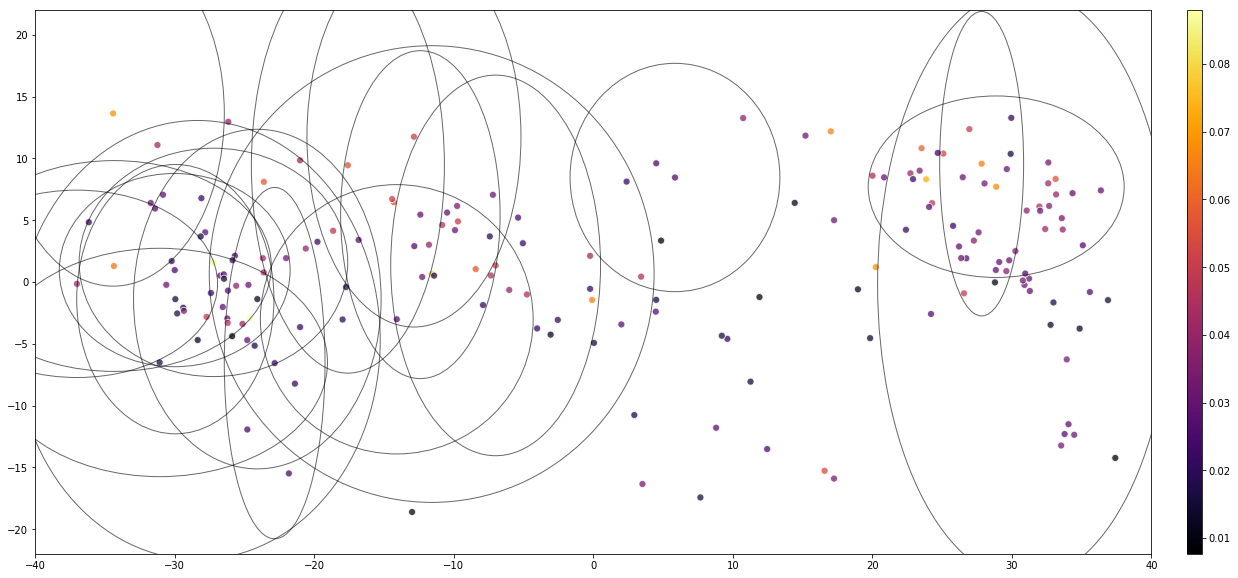

In [314]:
fig, ax = pl.subplots(figsize=(20,10))
ells = [Ellipse(xy=[linX[ri], linY[ri]], width=az_rfs[ri], height=el_rfs[ri]) for ri in range(nrois)
            if az_rfs[ri] > 0 and el_rfs[ri] > 0]

pl.scatter(linX, linY, s=50, c=magratios, cmap='inferno', alpha=0.75, edgecolors='w') #, vmin=0, vmax=2*np.pi)
magcmap=mpl.cm.inferno

pl.gca().invert_xaxis()  # Invert x-axis so that negative values are on left side
#    pl.xlim([retino_info['linminW'], retino_info['linmaxW']])
#    pl.ylim([retino_info['linminH'], retino_info['linmaxH']])
pl.xlim([-1*retino_info['width']/2., retino_info['width']/2.])
pl.ylim([-1*retino_info['height']/2., retino_info['height']/2.])

for ei,e in enumerate(ells[0:20]):
    ax.add_artist(e)
    #e.set_clip_box(ax.bbox)
    e.set_alpha(r2_values[0])
    #e.set_alpha(0.2)
    e.set_facecolor('none')
    e.set_linestyle('-')
    e.set_edgecolor('k')


pos = ax.get_position()
ax2 = fig.add_axes([pos.x0+.8, pos.y0, 0.01, pos.height])

alpha_min = magratios.min()
alpha_max = magratios.max()

magnorm = mpl.colors.Normalize(vmin=alpha_min, vmax=alpha_max)
cb = mpl.colorbar.ColorbarBase(ax2, cmap=magcmap, norm=magnorm, orientation='vertical')

pl.show()

[ 782.51686888  321.16491465   12.15992602]
('R2:', 0.53326334239979123)
(296, 342)
62
62


Text(0.5,1,u'roi000061')

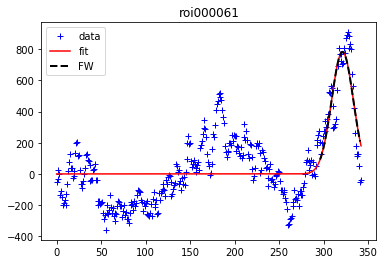

In [81]:
ncyles = len(framestart)
parsed_traces = np.zeros((ncycles,stimframes_incl))
for cycle in range(0,ncycles):
    parsed_traces[cycle,:]=roi_traces[curr_roi,framestart[cycle]:framestart[cycle]+stimframes_incl]

x0 = np.arange(0,parsed_traces.shape[-1])
y = np.mean(parsed_traces, axis=0)
#y2 = y0 - y0.min()

try:
    center_start = np.argmax(y)-(np.argmax(y)/1)
    center_end = np.argmax(y)+(np.argmax(y)/1)*2
    if center_start < 0:
        center_start = 0
    if center_end > len(y):
        center_end = len(y)
    centered = y[np.arange(center_start, center_end)]
    popt, pcov = curve_fit(gaus, x0, y, p0=(y[np.argmax(y)], np.argmax(y), 1))
                          
    y_fit = gaus(x0,*popt)
    print(popt)

    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print("R2:", r_squared)
    
except RuntimeError:
    print("Error - curve_fit failed")

if r_squared > fitness_threshold:
    
    fit_norm = y_fit/np.max(y_fit)

    border_start = np.where(fit_norm>=size_threshold)[0]
    if len(border_start)==0:
        border_start = 0
    else:
        border_start = border_start[0]
    border_end = np.where(fit_norm[border_start:]<=size_threshold)[0]
    if len(border_end) == 0:
        border_end = len(fit_norm)-1
    else:
        border_end = border_end[0]
    print(border_start, border_end) #rf_size_frames)

    # extrapolate around peak, in case edge:
    peak = np.argmax(y)
    tail2 = border_end - peak
    tail1 = peak - border_start
    if tail1 < tail2:
        border_edge1 = peak - tail2
        border_edge2 = peak + tail2
    elif tail2 < tail1:
        border_edge2 = peak + tail1
        border_edge1 = peak - tail1
    else:
        border_edge1 = peak - tail1
        border_edge2 = peak + tail2

    rf_size_frames = border_edge2 - border_edge1
    print rf_size_frames
else:
    rf_size_frames = 0

print rf_size_frames


plt.plot(y[0:], 'b+', label='data')
plt.plot(y_fit[0:], 'r', label='fit')
pl.plot(np.arange(border_start, border_end), y_fit[np.arange(border_start, border_end)], 
                'k--', linewidth=2, label='FW')
pl.legend()
pl.title('roi%06d' % (curr_roi+1))

In [217]:
# TODO: Check that found peak matches PHASE based on fft...

In [138]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
print(periodstartframes)

In [ ]:

# imdir = os.path.join(ref_data['data_dir'][analysisid],'Averaged_Slices_%s'\
#              %(ref_data['average_source'][analysisid]),'Channel%02d'%(signal_channel),
#              'File%03d'%(fidx+1))
# imfile = 'average_Slice%02d_Channel%02d_File%03d.tif'%(slidx+1, signal_channel, fidx+1)

# retinostruct['data'][fidx]['average_image_path']=os.path.join(imdir,imfile)

In [ ]:
#spatial smoothing, if indicated
#reshape





In [ ]:
#save magnitude, magnitude ratio, phase arrays